In [2]:
import sys
sys.path.append("../")

from jax import config; config.update("jax_enable_x64", True)
from jax import numpy as jnp
import numpy as np
from numba import njit


import polars as pl
from polars import col, lit

from sklearn.model_selection import train_test_split
from sklearn.utils.validation import check_is_fitted
from sklearn.exceptions import NotFittedError
from sklearn.ensemble import RandomForestRegressor, StackingRegressor
from sklearn.linear_model import LassoCV
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression as OLS
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.kernel_ridge import KernelRidge

from mapie.metrics import regression_coverage_score
from mapie.metrics import regression_mean_width_score
from mapie.regression import MapieQuantileRegressor, MapieRegressor

from plotnine import ggplot
import plotnine as p9

from utils.CLS import ConstrLS


# Import and Split Data
LINK = "http://www.bamlss.org/misc/rent99.raw"
df = pl.read_csv(LINK, separator=" ")
df = df.with_columns(col("yearc").cast(pl.Int32).cast(pl.Utf8).str.to_date(format="%Y")).rename({"yearc": "year"})


y = df["rent"]
X = df.drop("rent")

X_train, X_rest1, y_train, y_rest1 = train_test_split(X, y, test_size=2000, random_state=2)
X_test, X_rest2, y_test, y_rest2 = train_test_split(X_rest1, y_rest1, test_size=1500, random_state=4)
X_calib, X_new, y_calib, y_new = train_test_split(X_rest2, y_rest2, test_size=500, random_state=42)


In [17]:
LINK = (
    "https://raw.githubusercontent.com/scikit-learn-contrib/MAPIE/master/"
    "examples/data/demand_temperature.csv"
)

df = pl.read_csv(LINK)

# df.with_columns(col("").cast(pl.Utf8).str.to_date(format="%Y-%m-%d")).rename({"": "date"})
# Convert "2014-01-01 00:00:00" to datetime
df = df.rename({"": "date"}).with_columns(
    pl.col("date").cast(pl.Utf8).str.to_datetime(format="%Y-%m-%d %H:%M:%S")
)

df.head()

date,Demand,Temperature
datetime[μs],f64,f64
2014-01-01 00:00:00,3.794,18.05
2014-01-01 01:00:00,3.418,17.2
2014-01-01 02:00:00,3.152,16.45
2014-01-01 03:00:00,3.026,16.65
2014-01-01 04:00:00,3.022,16.4


In [18]:
from sklearn.datasets import fetch_openml

bike_sharing = fetch_openml("Bike_Sharing_Demand", version=2, as_frame=True)
df = bike_sharing.frame



In [2]:
# Stacking Model
estimators = [
    ('rf', RandomForestRegressor(n_estimators=100)),
    ('dt', DecisionTreeRegressor(max_depth=5)),
    ('ols', OLS()),
    ('xgb', XGBRegressor()),
    ('lgbm', LGBMRegressor()),
    ('mlp', MLPRegressor(hidden_layer_sizes=(100, 100))),
    ('kr', KernelRidge()),
    ('lasso', LassoCV())
    ]
    

model_stack = StackingRegressor(
    estimators=estimators,
    final_estimator=ConstrLS()
)

model_stack.fit(X_train, y_train)
w = model_stack.final_estimator_.coef_
weights = pl.DataFrame(
    {"estimator": model_stack.named_estimators.keys(),
        'weight': model_stack.final_estimator_.coef_},
    )
print(weights)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000571 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 643
[LightGBM] [Info] Number of data points in the train set: 1082, number of used features: 8
[LightGBM] [Info] Start training from score 454.415043
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000491 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 568
[LightGBM] [Info] Number of data points in the train set: 865, number of used features: 8
[LightGBM] [Info] Start training from score 453.117474
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000616 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, 

# Using Quantile Regression Conformal Predictions to get the stacking weights

In [5]:
from scipy.stats import randint, uniform
from sklearn.model_selection import RandomizedSearchCV, KFold
estimator = LGBMRegressor(
    objective='quantile',
    alpha=0.5,
    verbose=-1
)
params_distributions = dict(
    num_leaves=randint(low=10, high=50),
    max_depth=randint(low=3, high=20),
    n_estimators=randint(low=50, high=100),
    learning_rate=uniform()
)
optim_model = RandomizedSearchCV(
    estimator,
    param_distributions=params_distributions,
    n_jobs=-1,
    n_iter=10,
    cv=KFold(n_splits=5, shuffle=True),
)
optim_model.fit(X_train, y_train)
estimator = optim_model.best_estimator_


In [4]:
base_models = model_stack.estimators_


mapie = MapieQuantileRegressor(estimator, cv="split", alpha=0.05)
mapie.fit(
    X_train, y_train,
    X_calib=X_calib, y_calib=y_calib,
)

point, conf = mapie.predict(X_new)
lower, upper = conf[:, 0], conf[:, 1]

coverage_quantile = regression_coverage_score(y_new, lower, upper)
mean_width_quantile = regression_mean_width_score(lower, upper)


[RandomForestRegressor(),
 DecisionTreeRegressor(max_depth=5),
 LinearRegression(),
 XGBRegressor(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...),
 LGBMRegressor(),
 MLPRegressor(hidden_layer_sizes=(100, 100)),
 KernelRidge(),
 LassoCV()]

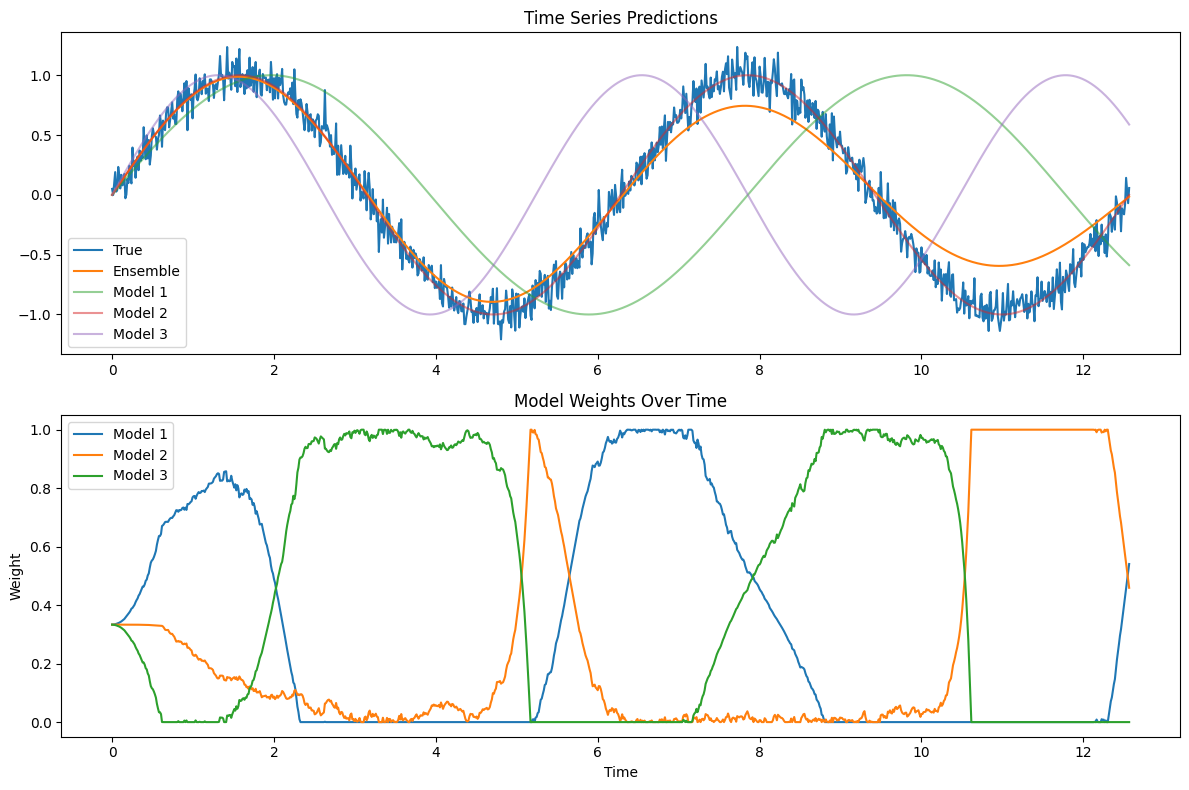

Final model weights: [0.54067308 0.45932692 0.        ]
Final MSE: 0.03917001092475152


In [7]:
import numpy as np
from scipy.stats import beta
import matplotlib.pyplot as plt

# Generate synthetic time series data
def generate_data(n_points, noise_level=0.1):
    t = np.linspace(0, 4*np.pi, n_points)
    y = np.sin(t) + np.random.normal(0, noise_level, n_points)
    return t, y

# Simple model class
class SimpleModel:
    def __init__(self, freq):
        self.freq = freq
    
    def predict(self, t):
        return np.sin(self.freq * t)

# Adaptive Ensemble class
class AdaptiveEnsemble:
    def __init__(self, models, learning_rate=0.1):
        self.models = models
        self.n_models = len(models)
        self.weights = np.ones(self.n_models) / self.n_models
        self.alpha = np.ones(self.n_models)
        self.beta = np.ones(self.n_models)
        self.learning_rate = learning_rate
    
    def predict(self, t):
        sampled_weights = np.array([beta.rvs(a, b) for a, b in zip(self.alpha, self.beta)])
        normalized_weights = sampled_weights / np.sum(sampled_weights)
        predictions = np.array([model.predict(t) for model in self.models])
        return np.dot(normalized_weights, predictions)
    
    def update(self, t, y_true):
        y_pred = self.predict(t)
        error = np.abs(y_true - y_pred)
        
        # Update performance distributions
        for i, model in enumerate(self.models):
            model_error = np.abs(y_true - model.predict(t))
            if model_error < error:
                self.alpha[i] += 1
            else:
                self.beta[i] += 1
        
        # Simple weight update
        grad = np.array([y_true - model.predict(t) for model in self.models])
        self.weights += self.learning_rate * grad
        self.weights = np.clip(self.weights, 0, None)
        self.weights /= np.sum(self.weights)

# Main experiment
np.random.seed(42)
n_points = 1000
t, y_true = generate_data(n_points)

models = [
    SimpleModel(0.8),  # Underestimating frequency
    SimpleModel(1.0),  # Correct frequency
    SimpleModel(1.2),  # Overestimating frequency
]

ensemble = AdaptiveEnsemble(models)

mse_history = []
weight_history = []

for i in range(n_points):
    y_pred = ensemble.predict(t[i])
    ensemble.update(t[i], y_true[i])
    
    mse = np.mean((y_true[:i+1] - ensemble.predict(t[:i+1]))**2)
    mse_history.append(mse)
    weight_history.append(ensemble.weights.copy())

# Plotting results
plt.figure(figsize=(12, 8))

plt.subplot(2, 1, 1)
plt.plot(t, y_true, label='True')
plt.plot(t, ensemble.predict(t), label='Ensemble')
for i, model in enumerate(models):
    plt.plot(t, model.predict(t), label=f'Model {i+1}', alpha=0.5)
plt.legend()
plt.title('Time Series Predictions')

plt.subplot(2, 1, 2)
weight_history = np.array(weight_history)
for i in range(ensemble.n_models):
    plt.plot(t, weight_history[:, i], label=f'Model {i+1}')
plt.legend()
plt.title('Model Weights Over Time')
plt.xlabel('Time')
plt.ylabel('Weight')

plt.tight_layout()
plt.show()

print("Final model weights:", ensemble.weights)
print("Final MSE:", mse_history[-1])